In [1]:
import pandas as pd
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import accuracy_score, classification_report, hamming_loss
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from google.colab import files
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score
import numpy as np
from sklearn.metrics import multilabel_confusion_matrix
import os

In [2]:
f = files.upload()

Saving all_data.csv to all_data.csv


In [3]:
# data read and extract feature matrix and target variable
data = pd.read_csv("all_data.csv")

x = data["sequence"]
y = data["goa"].apply(
    lambda k: [item for item in k.strip("[]").replace("'", "").split(', ')
               if item != '']).values
seq_list = x.to_list()

# Encoding sequences
def compute_kmer_frequencies(sequence, k) -> dict:
    kmer_counts = {}
    for i in range(len(sequence) - k + 1):
        kmer = sequence[i:i + k]
        kmer_counts[kmer] = kmer_counts.get(kmer, 0) + 1

    total_kmers = sum(kmer_counts.values())
    kmer_frequencies = {kmer: count / total_kmers for kmer, count in
                        kmer_counts.items()}
    return kmer_frequencies

kmer_freq = [compute_kmer_frequencies(seq, 1) for seq in seq_list]

# Transforming the k-mer Frequencies into a Feature Matrix:
vector = DictVectorizer(sparse=False)
X_vectorized = vector.fit_transform(kmer_freq)


#---------------#
# label info
label_list = []  # all labels
label_count = 0  # number of labels
label_dict = {}  # no of instances per label
for lst in y:
    for label in lst:
        if label not in label_list:
            label_list.append(label)
            label_dict[label] = 0
            label_count += 1
for lst in y:
    for label in lst:
        label_dict[label] += 1

sorted_labels_by_instance_numbers = sorted(label_dict.items(), key=lambda k: k[1])
# print(sorted_labels_by_instance_numbers)

label_list_with_less_than_3_instances =[]
for key in label_dict:
    if label_dict[key] < 3:
        label_list_with_less_than_3_instances.append(key)

print(len(label_list_with_less_than_3_instances)) # 7777 - sp.db

734


In [4]:
# Splitting the Dataset
X_t, X_test, y_t, y_test = train_test_split(X_vectorized, y,
                                                    test_size=0.2,
                                                    random_state=40)


X_train, X_validation, y_train, y_validation = train_test_split(X_t,y_t,test_size = 0.2, random_state = 40)


# Transforming target variable to a multilabel format
mlb = MultiLabelBinarizer(classes=label_list)
y_train = mlb.fit_transform(y_train)
y_valid = mlb.transform(y_validation)
y_test = mlb.transform(y_test)

# Standardization of feature values
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.fit_transform(X_validation)
X_test = scaler.transform(X_test)

In [5]:
# labels not present in the training data set
y_train_labels = mlb.inverse_transform(y_train)
y_valid_labels = mlb.inverse_transform(y_valid)
y_test_labels = mlb.inverse_transform(y_test)

# Convert to sets for easier comparison
train_label_set = {label for labels in y_train_labels for label in labels}
valid_label_set = {label for labels in y_valid_labels for label in labels}
test_label_set = {label for labels in y_test_labels for label in labels}

# Find labels present in test set but not in training set
missing_labels = test_label_set - train_label_set
missing_labels_valid = valid_label_set - train_label_set

print(len(missing_labels))
print("Labels present in test but missing in train:", missing_labels)

# print(len(valid_label_set))

77
Labels present in test but missing in train: {'GO:1905162', 'GO:0005164', 'GO:0009853', 'GO:0030162', 'GO:0003245', 'GO:0016984', 'GO:1903577', 'GO:0045041', 'GO:0071528', 'GO:0051482', 'GO:0120056', 'GO:0032543', 'GO:0010818', 'GO:0140494', 'GO:0002191', 'GO:0006458', 'GO:0031470', 'GO:0006446', 'GO:0048291', 'GO:1901799', 'GO:0042274', 'GO:0046625', 'GO:0005762', 'GO:0031870', 'GO:0032040', 'GO:0034185', 'GO:0004993', 'GO:0030135', 'GO:0010311', 'GO:0099589', 'GO:0051650', 'GO:0062073', 'GO:0045806', 'GO:0051702', 'GO:2001214', 'GO:0008494', 'GO:0010820', 'GO:0034186', 'GO:0046548', 'GO:0031262', 'GO:0001955', 'GO:0033602', 'GO:1990601', 'GO:0005839', 'GO:0002842', 'GO:0070254', 'GO:0034499', 'GO:0061028', 'GO:0061384', 'GO:0072429', 'GO:0004866', 'GO:0038036', 'GO:0045654', 'GO:0008035', 'GO:0032009', 'GO:1903979', 'GO:0000242', 'GO:0030594', 'GO:1903461', 'GO:0061351', 'GO:0019253', 'GO:0097524', 'GO:0042989', 'GO:0140299', 'GO:0030500', 'GO:2000073', 'GO:1903469', 'GO:1990927',

In [ ]:
# validation and finetuning
valid_acc = []
gamma= [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

for g in gamma:
  svm_classifier = OneVsRestClassifier(SVC(kernel='rbf', gamma=g))
  svm_classifier.fit(X_train, y_train)
  y_valid_pred = svm_classifier.predict(X_valid)
  accuracy = accuracy_score(y_valid_pred, y_valid)
  valid_acc.append(accuracy)



Text(0, 0.5, 'Accuracy')

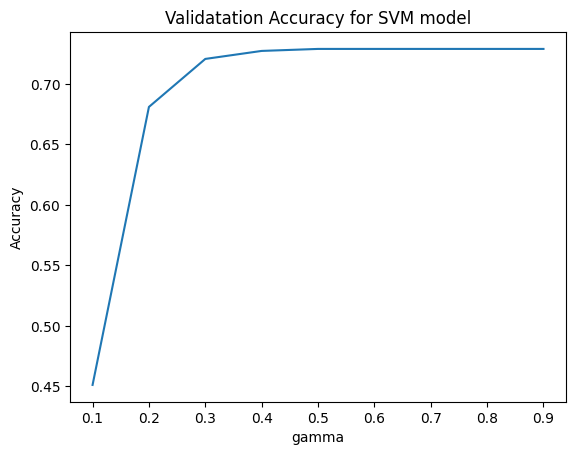

In [13]:
plt.title("Validatation Accuracy for SVM model")
plt.plot(gamma, valid_acc)
plt.xlabel("gamma")
plt.ylabel("Accuracy")

In [12]:
# Making predictions on the test data
svm_classifier = OneVsRestClassifier(SVC(kernel='rbf', gamma=0.5))
svm_classifier.fit(X_train, y_train)
y_pred = svm_classifier.predict(X_test)

In [20]:
# Accuracy for testing dataset
accuracy = accuracy_score(y_pred, y_test)
print(accuracy)

0.7129629629629629


In [ ]:
svm_classifier1 = OneVsRestClassifier(SVC(kernel='poly', degree=3, coef0=1))
svm_classifier1.fit(X_train, y_train)
y_pred_1 = svm_classifier1.predict(X_test)

In [19]:
# Calculating perfomance evaluation metrics Accuracy:
accuracy_rbf = accuracy_score(y_test, y_pred)
accuracy_poly = accuracy_score(y_test, y_pred_1)
loss_rbf = hamming_loss(y_test, y_pred)
loss_poly = hamming_loss(y_test, y_pred_1)

macro_precision = precision_score(y_test, y_pred, average='macro',zero_division=0)
macro_recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
micro_precision = precision_score(y_test, y_pred, average='micro',zero_division=0)
micro_recall = recall_score(y_test, y_pred, average='micro',zero_division=0)

print(f'Hamming Loss for RBF kernel: {loss_rbf}')  # Hamming Loss: 9.219777437219492e-05
print(f'Accuracy for RBF kernel: {accuracy_rbf}')

print(f'Hamming Loss for Polynomial kernel: {loss_poly}')  # Hamming Loss: 9.219777437219492e-05
print(f'Accuracy for Polynomial kernel: {accuracy_poly}')

print("Macro-averaged Precision for RBF:", macro_precision)
print("Macro-averaged Recall-RBF:", macro_recall)
print("Micro-averaged Precision-RBF:", micro_precision)
print("Micro-averaged Recall-RBF:", micro_recall)

Hamming Loss for RBF kernel: 0.0006312277976996628
Accuracy for RBF kernel: 0.7129629629629629
Hamming Loss for Polynomial kernel: 0.0013072908798405542
Accuracy for Polynomial kernel: 0.4246031746031746
Macro-averaged Precision for RBF: 0.5995676482595109
Macro-averaged Recall-RBF: 0.5524889188684058
Micro-averaged Precision-RBF: 0.9988020641356432
Micro-averaged Recall-RBF: 0.792092955276235


In [ ]:
# Accuracy Score for each of the labels

def calculate_label_accuracy(y_true, y_pred ):
    TP = np.sum((y_true == 1) & (y_pred == 1), axis=0)
    TN = np.sum((y_true == 0) & (y_pred == 0), axis=0)
    FP = np.sum((y_true == 0) & (y_pred == 1), axis=0)
    FN = np.sum((y_true == 1) & (y_pred == 0), axis=0)


    # Calculate accuracy for each label
    accuracy = (TP + TN) / (TP + FP + FN + TN)
    return accuracy

label_accuracies = calculate_label_accuracy(y_test, y_pred)

for label, accuracy in zip(mlb.classes_, label_accuracies):
    print(f"Accuracy for label {label}: {accuracy}\n")


In [ ]:
# Precision and recall for each of the labels
precisions = precision_score(y_test, y_pred, average=None, zero_division= 0)
recalls = recall_score(y_test, y_pred, average=None, zero_division= 0)

label_precisions = {label: precision for label, precision in zip(mlb.classes_, precisions)}
label_recalls = {label: recall for label, recall in zip(mlb.classes_, recalls)}

for label in mlb.classes_:
    print(f"Label: {label}")
    print(f" Precision: {label_precisions[label]}")
    print(f" Recall: {label_recalls[label]}\n")

In [ ]:
# Plot Confusion Matrix for each label
confusion_matrices = multilabel_confusion_matrix(y_test, y_pred)
for i, cm in enumerate(confusion_matrices):
    label_name = mlb.classes_[i]
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {label_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks(ticks=[0.5, 1.5], labels=['Negative', 'Positive'])
    plt.yticks(ticks=[0.5, 1.5], labels=['Negative', 'Positive'])
    plt.show()

In [ ]:
# Report for RBF kernel
r_rbf = classification_report(y_test, y_pred, zero_division=0, target_names= label_list)
print(r_rbf)

In [ ]:
# Report for Polynomial kernel
r_ply = classification_report(y_test, y_pred_1, zero_division=0, target_names= label_list)
print(r_ply)

In [ ]:
for idx in range(len(y_pred)):
    actual_labels = [mlb.classes_[i] for i, val in enumerate(y_test[idx]) if val == 1]
    predicted_labels = [mlb.classes_[i] for i, val in enumerate(y_pred[idx]) if val == 1]

    print(f"Instance {idx+1}:")
    print(f" Actual Labels: {actual_labels}")
    print(f" Predicted Labels: {predicted_labels}\n")